# MLP Population Generation Plots

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from pathlib import Path
import matplotlib as mpl
import seaborn as sns

In [10]:
df_paddy = pd.read_csv('MLP_Paddy_10Jan25_7692464_GENERATIONS.csv')
df_paddy

,Repeat,Generation,F1_Score,Time
0,1,1,0.388066,197.24
1,1,2,0.460553,197.24
2,1,3,0.473766,197.24
3,1,4,0.502600,197.24
4,1,5,0.536443,197.24
...,...,...,...,...
795,100,4,0.527030,237.32
796,100,5,0.535241,237.32
797,100,6,0.568879,237.32
798,100,7,0.576088,237.32


In [11]:
df_Evo_GA = pd.read_csv('MLP_evotorch_10Jan25_GA_7706549_GENERATION.csv')
df_Evo_GA

,Repeat,Generation,F1_Score
0,1,1,0.3879
1,1,2,0.3879
2,1,3,0.3937
3,1,4,0.3981
4,1,5,0.3981
...,...,...,...
795,100,4,0.4169
796,100,5,0.4169
797,100,6,0.4169
798,100,7,0.4177


In [12]:
df_Evo_EA = pd.read_csv('MLP_evotorch_11Jan25_EA_7696589_GENERATIONS.csv')
df_Evo_EA

,Repeat,Generation,F1_Score
0,1,1,0.3674
1,1,2,0.3831
2,1,3,0.3831
3,1,4,0.3831
4,1,5,0.3895
...,...,...,...
795,100,4,0.3909
796,100,5,0.3945
797,100,6,0.4017
798,100,7,0.4017


# Generations Plot

Successfully read MLP_Paddy_10Jan25_7692464_GENERATIONS.csv
Successfully read MLP_evotorch_11Jan25_EA_7696589_GENERATIONS.csv
Successfully read MLP_evotorch_10Jan25_GA_7706549_GENERATION.csv


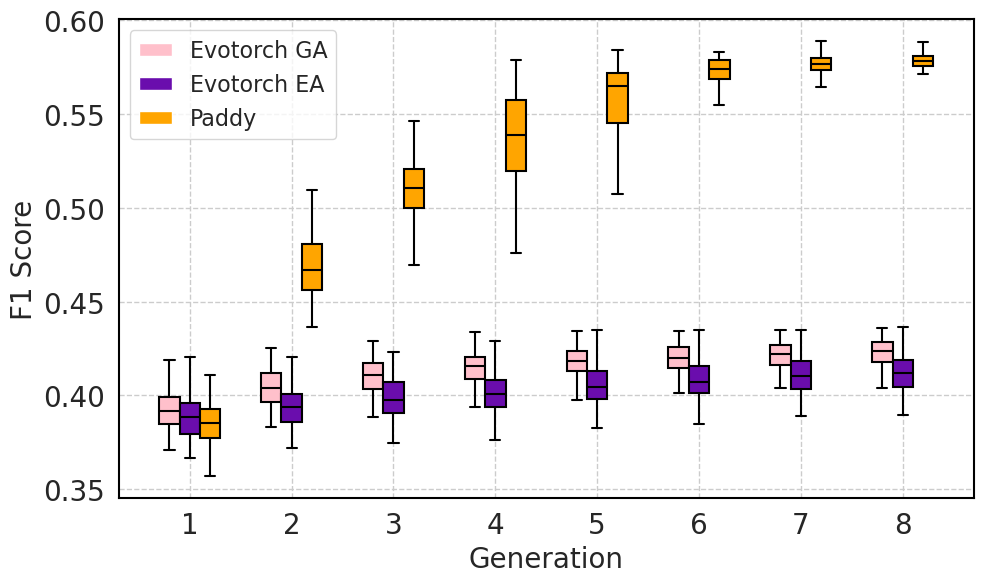

In [15]:
def create_grouped_boxplot_by_trial(
    file_paths, 
    custom_labels=None, 
    colors=None,
    spine_color='black',          # Added parameter for spine color
    spine_linewidth=1.5,          # Added parameter for spine linewidth
    tick_label_size=20,           # Added parameter for tick label font size
    xlabel_size=20,               # Added parameter for x-axis label font size
    ylabel_size=20,               # Added parameter for y-axis label font size
    grid_alpha=1.0,               # Adjusted gridline transparency to match scatter plot
    figsize=(10, 6)               # Added parameter for figure size
):
    """
    Create a grouped boxplot showing the F1 Score distribution for each Generation from multiple files using Matplotlib.

    Parameters:
    - file_paths (list): List of paths to CSV/Excel files.
    - custom_labels (dict, optional): Dictionary mapping original source file names to custom labels.
    - colors (list, optional): List of colors to use for the boxplots. Must match the number of datasets.
    - spine_color (str, optional): Color of the plot spines. Default is 'black'.
    - spine_linewidth (float, optional): Linewidth of the plot spines. Default is 1.5.
    - tick_label_size (int, optional): Font size for tick labels. Default is 20.
    - xlabel_size (int, optional): Font size for the x-axis label. Default is 20.
    - ylabel_size (int, optional): Font size for the y-axis label. Default is 20.
    - grid_alpha (float, optional): Transparency level for gridlines. Default is 1.0 (fully opaque).
    - figsize (tuple, optional): Size of the matplotlib figure. Default is (12, 6).

    Returns:
    - fig, ax: Matplotlib figure and axes objects.
    """
    # Set global font and SVG settings for consistency
    mpl.rcParams['svg.fonttype'] = 'none'  # Keep text as text in SVG
    plt.rcParams['font.family'] = 'Arial'  # Use a universal font

    # Use Seaborn for enhanced aesthetics
    sns.set(style="whitegrid")

    # Initialize an empty list to store all dataframes
    all_data = []

    # Read and combine all files
    for file_path in file_paths:
        try:
            if file_path.endswith('.csv'):
                df = pd.read_csv(file_path)
            elif file_path.endswith(('.xlsx', '.xls')):
                df = pd.read_excel(file_path)
            else:
                print(f"Unsupported file format: {file_path}")
                continue
            print(f"Successfully read {file_path}")
            
            # Ensure required columns are present
            if not {'Generation', 'F1_Score', 'Repeat'}.issubset(df.columns):
                print(f"Missing required columns in {file_path}")
                continue
            
            df = df[['Generation', 'F1_Score', 'Repeat']]
            df['Source_File'] = Path(file_path).stem  # Add a column for the source file name
            all_data.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    if not all_data:
        print("No data to plot.")
        return None, None

    # Combine all dataframes
    combined_df = pd.concat(all_data, ignore_index=True)

    # If custom_labels is provided, replace the Source_File names
    if custom_labels:
        combined_df['Source_File'] = combined_df['Source_File'].replace(custom_labels)

    # Aggregate data for grouped boxplots
    combined_df_grouped = combined_df.groupby(['Generation', 'Source_File'])['F1_Score'].apply(list).unstack(fill_value=[])

    generations = combined_df_grouped.index.tolist()
    datasets = combined_df_grouped.columns.tolist()
    width = 0.2  # Width of each boxplot group

    # Validate colors
    if colors and len(colors) != len(datasets):
        raise ValueError("The number of colors must match the number of datasets.")
    elif not colors:
        colors = [f"C{i}" for i in range(len(datasets))]  # Default to matplotlib's colors

    # Sort datasets to match the desired order: Evotorch GA, Evotorch EA, Paddy
    desired_order = ["Evotorch GA", "Evotorch EA", "Paddy"]
    # Reorder datasets and colors accordingly
    dataset_color_map = dict(zip(datasets, colors))
    datasets = [d for d in desired_order if d in datasets]
    colors = [dataset_color_map[d] for d in datasets]

    # Initialize the plot with style matching the MSE code
    fig, ax = plt.subplots(figsize=figsize)

    # Plot each dataset for each generation with styled boxplots
    for i, dataset in enumerate(datasets):
        positions = np.arange(len(generations)) + (i - len(datasets) / 2) * width + width / 2
        bp = ax.boxplot(
            combined_df_grouped[dataset].tolist(),
            positions=positions,
            patch_artist=True,
            showfliers=False,
            widths=width,
            # Style the boxplots to match MSE code
            boxprops=dict(linewidth=1.5, color='black'),
            whiskerprops=dict(linewidth=1.5, color='black'),
            capprops=dict(linewidth=1.5, color='black'),
            medianprops=dict(linewidth=1.5, color='black'),
            flierprops=dict(marker=None, color="black", alpha=0.7),
        )

        # Set the facecolor for each box to be fully opaque
        for box in bp['boxes']:
            box.set(facecolor=colors[i])  # Removed alpha for full opacity

    # Customize plot to match MSE code styling
    ax.set_xlabel('Generation', fontsize=xlabel_size)
    ax.set_ylabel('F1 Score', fontsize=ylabel_size)
    ax.set_xticks(np.arange(len(generations)))
    ax.set_xticklabels([f"{g}" for g in generations], fontsize=tick_label_size)
    ax.tick_params(axis='y', labelsize=tick_label_size)  # Set tick label sizes on the y-axis
    ax.tick_params(axis='x', labelsize=tick_label_size)  # Set tick label sizes on the x-axis

    # Add grid lines (both horizontal and vertical) with adjusted transparency
    ax.grid(axis='both', linestyle='--', alpha=grid_alpha)

    # Set the spine colors and thickness for all spines (left, bottom, top, right)
    for spine_name, spine in ax.spines.items():
        spine.set_edgecolor(spine_color)
        spine.set_linewidth(spine_linewidth)

    # Create custom legend handles
    legend_handles = [
        mpatches.Patch(facecolor=colors[i], label=datasets[i]) 
        for i in range(len(datasets))
    ]
    ax.legend(
        handles=legend_handles, 
        fontsize=16, 
        loc='upper left',
        handleheight=0.5,
        handlelength=1.5,
        title=None
    )

    # Adjust layout for readability
    plt.tight_layout()

    return fig, ax


# Example usage:
if __name__ == "__main__":
    import matplotlib as mpl

    # Ensure fonts are embedded in the SVG
    mpl.rcParams['svg.fonttype'] = 'none'  # This ensures text is stored as text, not paths
    plt.rcParams['font.family'] = 'Arial'  # Use a universal font

    file_paths = [
        'MLP_Paddy_10Jan25_7692464_GENERATIONS.csv',
        'MLP_evotorch_11Jan25_EA_7696589_GENERATIONS.csv',
        'MLP_evotorch_10Jan25_GA_7706549_GENERATION.csv',
    ]

    custom_labels = {
        'MLP_Paddy_10Jan25_7692464_GENERATIONS': 'Paddy',
        'MLP_evotorch_11Jan25_EA_7696589_GENERATIONS': 'Evotorch EA',
        'MLP_evotorch_10Jan25_GA_7706549_GENERATION': 'Evotorch GA',
    }

    custom_colors = ['#6A0DAD', '#FFC0CB', '#FFA500']

    fig, ax = create_grouped_boxplot_by_trial(
        file_paths, 
        custom_labels=custom_labels, 
        colors=custom_colors,
        spine_color='black',          # Ensure spine color is black
        spine_linewidth=1.5,          # Set spine linewidth to 2.0 for better visibility
        tick_label_size=20,           # Adjust tick label size as needed
        xlabel_size=20,               # Set x-axis label font size
        ylabel_size=20,               # Set y-axis label font size
        grid_alpha=1.0,               # Fully opaque gridlines
        figsize=(10, 6)               # Set figure size
    )
    if fig and ax:
        # Save the plot as PNG
        plt.savefig('MLP_GenerationalData_PaddyEvotorch.png', dpi=300, bbox_inches='tight')
        # Save the plot as SVG with fixed font handling
        plt.savefig('MLP_GenerationalData_PaddyEvotorch.svg', dpi=300, bbox_inches='tight', format='svg')
        plt.show()

